In [ ]:
# Load Libraries 
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
from tensorflow.python.keras.layers import Lambda
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Input
from sklearn.preprocessing import MinMaxScaler
import h5py
import math
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from google.colab import files
from numpy import savetxt
from keras.utils.vis_utils import plot_model
np.random.seed(20)   
tf.random.set_seed(20)

In [ ]:
# Mount Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Function: Create Data History
def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1] 
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

In [ ]:
# Load the data
data1 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data/p5270_Data.mat')
data2 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data/p5270MechData.mat')
a_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2), 'freqQAmpI_filt':data1['freqQAmpI_filt'].ravel()})
w_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2),'C_filt':data1['C_filt'].ravel()})
m_t = pd.DataFrame({'Time':data1['Time'].ravel().round(2), 'SS':data1['SS'].ravel()}) 
s_t = pd.DataFrame({'Time':data2['Time'].ravel().round(2), 'V':data2['V'].ravel(),'V_filt':data2['V_filt'].ravel()})
df = a_t.merge(w_t, on='Time')
df = df.merge(m_t, on='Time')
df = df.merge(s_t, on='Time')
df = df[['freqQAmpI_filt', 'C_filt','Time','V_filt','SS']]
df_SS = df[['freqQAmpI_filt','C_filt','SS']] 
df_V = df[['freqQAmpI_filt','C_filt','V_filt']] 
df_A = df[['freqQAmpI_filt','C_filt','freqQAmpI_filt']]
df_WV = df[['freqQAmpI_filt','C_filt','C_filt']]
xdf = df[['freqQAmpI_filt', 'C_filt']]
ydf = df[['SS','V_filt']]
print("Input Data:\n", xdf)
print("Target Data:\n",ydf)

Input Data:
         freqQAmpI_filt       C_filt
0         31453.223522  5490.232850
1         31438.277060  5490.239343
2         31421.341616  5490.240838
3         31409.798761  5490.232728
4         31398.815589  5490.222463
...                ...          ...
132394    31055.686766  5457.051859
132395    31041.955345  5457.082380
132396    31035.059531  5457.111463
132397    31020.001291  5457.126443
132398    31012.016780  5457.151945

[132399 rows x 2 columns]
Target Data:
               SS    V_filt
0       5.656166  1.201004
1       5.657157  1.243144
2       5.658317  1.264215
3       5.659499  1.243144
4       5.660404  1.222074
...          ...       ...
132394  5.471059  1.285285
132395  5.474545  0.948161
132396  5.478286  1.158863
132397  5.481751  1.201004
132398  5.484813  0.526756

[132399 rows x 2 columns]


In [ ]:
# Preprocessing (SS)
arr = df_SS.to_numpy()
n_steps = 300
xdf, ydf_SS = create_timesteps(arr, n_steps)

# Preprocessing (V)
arr = df_V.to_numpy()
n_steps = 300
xdf, ydf_V = create_timesteps(arr, n_steps)

# Preprocessing (A)
arr = df_A.to_numpy()
n_steps = 300
xdf, ydf_A = create_timesteps(arr, n_steps)

# Preprocessing (WV)
arr = df_WV.to_numpy()
n_steps = 300
xdf, ydf_WV = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape (SS), Y = ', np.shape(ydf_SS))
print('Target shape (V), Y = ', np.shape(ydf_V))

# Reshape 
in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))

Features shape, X =  (132099, 300, 2)
Target shape (SS), Y =  (132099,)
Target shape (V), Y =  (132099,)
After reshaping, X =  (132099, 600)


In [ ]:
# Split into train-val-test (SS)
x_train, x_test, y_train_SS, y_test_SS = train_test_split(xdf, ydf_SS, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_SS, Y_val_SS = train_test_split(x_train, y_train_SS, test_size=0.125, shuffle=False)

# Split into train-val-test (V)
x_train, x_test, y_train_V, y_test_V = train_test_split(xdf, ydf_V, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_V, Y_val_V = train_test_split(x_train, y_train_V, test_size=0.125, shuffle=False)

# Select Train
X_train = X_train[13210:92469] 
Y_train_SS = Y_train_SS[13210:92469]
Y_train_V = Y_train_V[13210:92469]

# Normalize the input
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training samples:", np.shape(X_train)[0])
print("Validation samples:", np.shape(X_val)[0])
print("Testing samples:", np.shape(x_test)[0])

Training samples: 79259
Validation samples: 13210
Testing samples: 26420


In [ ]:
# Normalize the output: SS
scaler_ss = MinMaxScaler()
Y_train_SS = pd.DataFrame(scaler_ss.fit_transform(Y_train_SS.reshape(-1, 1)))
Y_val_SS = pd.DataFrame(scaler_ss.transform(Y_val_SS.reshape(-1, 1)))
y_test_SS = pd.DataFrame(scaler_ss.transform(y_test_SS.reshape(-1, 1)))

In [ ]:
# Normalize the output: V
scaler_v = MinMaxScaler()
Y_train_V = pd.DataFrame(scaler_v.fit_transform(Y_train_V.reshape(-1, 1)))
Y_val_V = pd.DataFrame(scaler_v.transform(Y_val_V.reshape(-1, 1)))
y_test_V = pd.DataFrame(scaler_v.transform(y_test_V.reshape(-1, 1)))

**Define Data-Driven Model**

In [ ]:
# Define DD
def MLP_Data():

  # Define inputs
  X_train = layers.Input(shape=(600),name='X_train')    

  # Prediction: Shear Stress + Slip Rate
  x = layers.Dense(128,kernel_initializer = 'normal', activation="relu")(X_train)
  x = layers.Dense(64,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(32,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(16, kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(8, kernel_initializer = 'normal', activation="relu")(x)
  ss_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)
  v_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)

  model = keras.Model(inputs=[X_train],outputs=[ss_pred,v_pred])
  return model

In [ ]:
# Model Summary
model=MLP_Data()
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['mse'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 X_train (InputLayer)           [(None, 600)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          76928       ['X_train[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 64)           8256        ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 32)           2080        ['dense_1[0][0]']                
                                                                                              

Train on 79259 samples, validate on 13210 samples
Epoch 1/100
79168/79259 [============================>.] - ETA: 0s - loss: 0.0283 - dense_5_loss: 0.0190 - dense_6_loss: 0.0093 - dense_5_mse: 0.0190 - dense_6_mse: 0.0093

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 0.01804, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


79259/79259 [==============================] - 10s 122us/sample - loss: 0.0283 - dense_5_loss: 0.0190 - dense_6_loss: 0.0093 - dense_5_mse: 0.0190 - dense_6_mse: 0.0093 - val_loss: 0.0180 - val_dense_5_loss: 0.0033 - val_dense_6_loss: 0.0147 - val_dense_5_mse: 0.0033 - val_dense_6_mse: 0.0147
Epoch 2/100
78624/79259 [============================>.] - ETA: 0s - loss: 0.0124 - dense_5_loss: 0.0030 - dense_6_loss: 0.0094 - dense_5_mse: 0.0030 - dense_6_mse: 0.0094
Epoch 2: val_loss improved from 0.01804 to 0.01641, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


79259/79259 [==============================] - 8s 102us/sample - loss: 0.0124 - dense_5_loss: 0.0030 - dense_6_loss: 0.0094 - dense_5_mse: 0.0030 - dense_6_mse: 0.0094 - val_loss: 0.0164 - val_dense_5_loss: 0.0018 - val_dense_6_loss: 0.0146 - val_dense_5_mse: 0.0018 - val_dense_6_mse: 0.0146
Epoch 3/100
79136/79259 [============================>.] - ETA: 0s - loss: 0.0109 - dense_5_loss: 0.0029 - dense_6_loss: 0.0080 - dense_5_mse: 0.0029 - dense_6_mse: 0.0080
Epoch 3: val_loss improved from 0.01641 to 0.01203, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


79259/79259 [==============================] - 8s 103us/sample - loss: 0.0109 - dense_5_loss: 0.0029 - dense_6_loss: 0.0080 - dense_5_mse: 0.0029 - dense_6_mse: 0.0080 - val_loss: 0.0120 - val_dense_5_loss: 0.0024 - val_dense_6_loss: 0.0096 - val_dense_5_mse: 0.0024 - val_dense_6_mse: 0.0096
Epoch 4/100
78848/79259 [============================>.] - ETA: 0s - loss: 0.0087 - dense_5_loss: 0.0033 - dense_6_loss: 0.0053 - dense_5_mse: 0.0033 - dense_6_mse: 0.0053
Epoch 4: val_loss improved from 0.01203 to 0.00803, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


79259/79259 [==============================] - 8s 104us/sample - loss: 0.0087 - dense_5_loss: 0.0033 - dense_6_loss: 0.0054 - dense_5_mse: 0.0033 - dense_6_mse: 0.0054 - val_loss: 0.0080 - val_dense_5_loss: 0.0027 - val_dense_6_loss: 0.0053 - val_dense_5_mse: 0.0027 - val_dense_6_mse: 0.0053
Epoch 5/100
78976/79259 [============================>.] - ETA: 0s - loss: 0.0080 - dense_5_loss: 0.0031 - dense_6_loss: 0.0050 - dense_5_mse: 0.0031 - dense_6_mse: 0.0050
Epoch 5: val_loss improved from 0.00803 to 0.00566, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


79259/79259 [==============================] - 8s 102us/sample - loss: 0.0080 - dense_5_loss: 0.0031 - dense_6_loss: 0.0050 - dense_5_mse: 0.0031 - dense_6_mse: 0.0050 - val_loss: 0.0057 - val_dense_5_loss: 0.0027 - val_dense_6_loss: 0.0030 - val_dense_5_mse: 0.0027 - val_dense_6_mse: 0.0030
Epoch 6/100
79040/79259 [============================>.] - ETA: 0s - loss: 0.0067 - dense_5_loss: 0.0026 - dense_6_loss: 0.0041 - dense_5_mse: 0.0026 - dense_6_mse: 0.0041
Epoch 6: val_loss did not improve from 0.00566
79259/79259 [==============================] - 7s 86us/sample - loss: 0.0067 - dense_5_loss: 0.0026 - dense_6_loss: 0.0041 - dense_5_mse: 0.0026 - dense_6_mse: 0.0041 - val_loss: 0.0164 - val_dense_5_loss: 0.0038 - val_dense_6_loss: 0.0126 - val_dense_5_mse: 0.0038 - val_dense_6_mse: 0.0126
Epoch 7/100
78880/79259 [============================>.] - ETA: 0s - loss: 0.0076 - dense_5_loss: 0.0028 - dense_6_loss: 0.0048 - dense_5_mse: 0.0028 - dense_6_mse: 0.0048
Epoch 7: val_loss did no

79259/79259 [==============================] - 9s 114us/sample - loss: 0.0067 - dense_5_loss: 0.0025 - dense_6_loss: 0.0042 - dense_5_mse: 0.0025 - dense_6_mse: 0.0042 - val_loss: 0.0046 - val_dense_5_loss: 0.0015 - val_dense_6_loss: 0.0031 - val_dense_5_mse: 0.0015 - val_dense_6_mse: 0.0031
Epoch 10/100
78784/79259 [============================>.] - ETA: 0s - loss: 0.0064 - dense_5_loss: 0.0025 - dense_6_loss: 0.0040 - dense_5_mse: 0.0025 - dense_6_mse: 0.0040
Epoch 10: val_loss did not improve from 0.00460
79259/79259 [==============================] - 7s 86us/sample - loss: 0.0064 - dense_5_loss: 0.0025 - dense_6_loss: 0.0040 - dense_5_mse: 0.0025 - dense_6_mse: 0.0040 - val_loss: 0.0050 - val_dense_5_loss: 0.0016 - val_dense_6_loss: 0.0034 - val_dense_5_mse: 0.0016 - val_dense_6_mse: 0.0034
Epoch 11/100
79040/79259 [============================>.] - ETA: 0s - loss: 0.0054 - dense_5_loss: 0.0021 - dense_6_loss: 0.0033 - dense_5_mse: 0.0021 - dense_6_mse: 0.0033
Epoch 11: val_loss di

79259/79259 [==============================] - 8s 101us/sample - loss: 0.0046 - dense_5_loss: 0.0018 - dense_6_loss: 0.0028 - dense_5_mse: 0.0018 - dense_6_mse: 0.0028 - val_loss: 0.0039 - val_dense_5_loss: 0.0019 - val_dense_6_loss: 0.0019 - val_dense_5_mse: 0.0019 - val_dense_6_mse: 0.0019
Epoch 13/100
78880/79259 [============================>.] - ETA: 0s - loss: 0.0051 - dense_5_loss: 0.0021 - dense_6_loss: 0.0030 - dense_5_mse: 0.0021 - dense_6_mse: 0.0030
Epoch 13: val_loss did not improve from 0.00387
79259/79259 [==============================] - 7s 85us/sample - loss: 0.0051 - dense_5_loss: 0.0021 - dense_6_loss: 0.0030 - dense_5_mse: 0.0021 - dense_6_mse: 0.0030 - val_loss: 0.0041 - val_dense_5_loss: 0.0018 - val_dense_6_loss: 0.0023 - val_dense_5_mse: 0.0018 - val_dense_6_mse: 0.0023
Epoch 14/100
78656/79259 [============================>.] - ETA: 0s - loss: 0.0048 - dense_5_loss: 0.0020 - dense_6_loss: 0.0028 - dense_5_mse: 0.0020 - dense_6_mse: 0.0028
Epoch 14: val_loss di

79259/79259 [==============================] - 8s 103us/sample - loss: 0.0044 - dense_5_loss: 0.0018 - dense_6_loss: 0.0026 - dense_5_mse: 0.0018 - dense_6_mse: 0.0026 - val_loss: 0.0027 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0016 - val_dense_5_mse: 0.0011 - val_dense_6_mse: 0.0016
Epoch 17/100
79104/79259 [============================>.] - ETA: 0s - loss: 0.0039 - dense_5_loss: 0.0016 - dense_6_loss: 0.0023 - dense_5_mse: 0.0016 - dense_6_mse: 0.0023
Epoch 17: val_loss did not improve from 0.00269
79259/79259 [==============================] - 8s 107us/sample - loss: 0.0039 - dense_5_loss: 0.0016 - dense_6_loss: 0.0023 - dense_5_mse: 0.0016 - dense_6_mse: 0.0023 - val_loss: 0.0030 - val_dense_5_loss: 0.0012 - val_dense_6_loss: 0.0018 - val_dense_5_mse: 0.0012 - val_dense_6_mse: 0.0018
Epoch 18/100
78912/79259 [============================>.] - ETA: 0s - loss: 0.0044 - dense_5_loss: 0.0017 - dense_6_loss: 0.0027 - dense_5_mse: 0.0017 - dense_6_mse: 0.0027
Epoch 18: val_loss d

79259/79259 [==============================] - 8s 106us/sample - loss: 0.0034 - dense_5_loss: 0.0014 - dense_6_loss: 0.0020 - dense_5_mse: 0.0014 - dense_6_mse: 0.0020 - val_loss: 0.0026 - val_dense_5_loss: 0.0010 - val_dense_6_loss: 0.0015 - val_dense_5_mse: 0.0010 - val_dense_6_mse: 0.0015
Epoch 25/100
78912/79259 [============================>.] - ETA: 0s - loss: 0.0036 - dense_5_loss: 0.0015 - dense_6_loss: 0.0022 - dense_5_mse: 0.0015 - dense_6_mse: 0.0022
Epoch 25: val_loss did not improve from 0.00255
79259/79259 [==============================] - 7s 84us/sample - loss: 0.0036 - dense_5_loss: 0.0015 - dense_6_loss: 0.0022 - dense_5_mse: 0.0015 - dense_6_mse: 0.0022 - val_loss: 0.0028 - val_dense_5_loss: 0.0014 - val_dense_6_loss: 0.0014 - val_dense_5_mse: 0.0014 - val_dense_6_mse: 0.0014
Epoch 26/100
78720/79259 [============================>.] - ETA: 0s - loss: 0.0032 - dense_5_loss: 0.0013 - dense_6_loss: 0.0019 - dense_5_mse: 0.0013 - dense_6_mse: 0.0019
Epoch 26: val_loss di

79259/79259 [==============================] - 10s 129us/sample - loss: 0.0027 - dense_5_loss: 0.0011 - dense_6_loss: 0.0016 - dense_5_mse: 0.0011 - dense_6_mse: 0.0016 - val_loss: 0.0021 - val_dense_5_loss: 8.9979e-04 - val_dense_6_loss: 0.0012 - val_dense_5_mse: 8.9974e-04 - val_dense_6_mse: 0.0012
Epoch 41/100
79232/79259 [============================>.] - ETA: 0s - loss: 0.0026 - dense_5_loss: 0.0011 - dense_6_loss: 0.0015 - dense_5_mse: 0.0011 - dense_6_mse: 0.0015
Epoch 41: val_loss did not improve from 0.00213
79259/79259 [==============================] - 7s 87us/sample - loss: 0.0026 - dense_5_loss: 0.0011 - dense_6_loss: 0.0015 - dense_5_mse: 0.0011 - dense_6_mse: 0.0015 - val_loss: 0.0033 - val_dense_5_loss: 0.0010 - val_dense_6_loss: 0.0023 - val_dense_5_mse: 0.0010 - val_dense_6_mse: 0.0023
Epoch 42/100
79259/79259 [==============================] - ETA: 0s - loss: 0.0024 - dense_5_loss: 0.0010 - dense_6_loss: 0.0014 - dense_5_mse: 0.0010 - dense_6_mse: 0.0014
Epoch 42: va

79259/79259 [==============================] - 8s 106us/sample - loss: 0.0022 - dense_5_loss: 8.8242e-04 - dense_6_loss: 0.0013 - dense_5_mse: 8.8241e-04 - dense_6_mse: 0.0013 - val_loss: 0.0021 - val_dense_5_loss: 8.4835e-04 - val_dense_6_loss: 0.0012 - val_dense_5_mse: 8.4825e-04 - val_dense_6_mse: 0.0012
Epoch 58/100
79072/79259 [============================>.] - ETA: 0s - loss: 0.0022 - dense_5_loss: 9.1665e-04 - dense_6_loss: 0.0013 - dense_5_mse: 9.1665e-04 - dense_6_mse: 0.0013
Epoch 58: val_loss did not improve from 0.00207
79259/79259 [==============================] - 7s 87us/sample - loss: 0.0022 - dense_5_loss: 9.1581e-04 - dense_6_loss: 0.0013 - dense_5_mse: 9.1584e-04 - dense_6_mse: 0.0013 - val_loss: 0.0024 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0013 - val_dense_5_mse: 0.0011 - val_dense_6_mse: 0.0013
Epoch 59/100
78976/79259 [============================>.] - ETA: 0s - loss: 0.0021 - dense_5_loss: 8.3701e-04 - dense_6_loss: 0.0012 - dense_5_mse: 8.3701e-04 - d

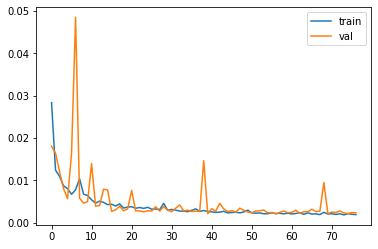

---Training time: 552.22726369 seconds ---


In [ ]:
# Train The Model
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20,verbose=1, mode='auto')  
checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check', monitor='val_loss', verbose=1, save_best_only=True, mode='min')  
callbacks_list = [earlystop, checkpoint]
start_time = time.time()
history = model.fit([X_train],[Y_train_SS,Y_train_V], epochs=100, batch_size=32,callbacks=callbacks_list,
                     validation_data=([X_val],[Y_val_SS,Y_val_V]), verbose=1)
end_time = time.time()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()
print("---Training time: %0.8f seconds ---" % (end_time - start_time))

In [ ]:
# # Save the model
# print(model.summary())
# plot_model(model, show_shapes=True)
# model.save('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/Reference_p5270/Reference/DD_Transfer_model_70_10_20.h5')

In [ ]:
# Model Performance: Training
y_predtrain = model.predict([X_train])
y_predtrain_SS = np.array(y_predtrain)[0,] 
y_predtrain_V =np.array(y_predtrain)[1,] 

train_r2_SS = r2_score(Y_train_SS, y_predtrain_SS) 
train_rmse_SS = np.sqrt(mean_squared_error(Y_train_SS, y_predtrain_SS)) 

train_r2_V = r2_score(Y_train_V,y_predtrain_V ) 
train_rmse_V = np.sqrt(mean_squared_error(Y_train_V, y_predtrain_V )) 

# Model Performance: Validation 
y_predval = model.predict([X_val])
y_predval_SS = np.array(y_predval)[0,] 
y_predval_V = np.array(y_predval)[1,] 

val_r2_SS = r2_score(Y_val_SS, y_predval_SS) 
val_rmse_SS = np.sqrt(mean_squared_error(Y_val_SS, y_predval_SS)) 

val_r2_V = r2_score(Y_val_V, y_predval_V) 
val_rmse_V = np.sqrt(mean_squared_error(Y_val_V, y_predval_V)) 

# Model Performance: Testing 
y_predtest = model.predict([x_test])
y_predtest_SS =np.array(y_predtest)[0,] 
y_predtest_V = np.array(y_predtest)[1,] 

test_r2_SS = r2_score(y_test_SS,y_predtest_SS) 
test_rmse_SS = np.sqrt(mean_squared_error(y_test_SS, y_predtest_SS)) 

test_r2_V = r2_score(y_test_V,y_predtest_V) 
test_rmse_V = np.sqrt(mean_squared_error(y_test_V, y_predtest_V)) 

# Print R2 Results 
print("R2 scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_r2_SS , train_r2_V))
print("R2 scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_r2_SS , val_r2_V))
print("R2 scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_r2_SS , test_r2_V))

# Print RSME Results
print("RMSE scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_rmse_SS , train_rmse_V))
print("RMSE scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_rmse_SS , val_rmse_V))
print("RMSE scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_rmse_SS , test_rmse_V))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


R2 scores: Train (SS) - 0.97212, Train (V) - 0.90196
R2 scores: Validation (SS) - 0.97544, Validation (V) - 0.89462
R2 scores: Testing (SS) - 0.94411, Testing (V) - 0.83384
RMSE scores: Train (SS) - 0.02802, Train (V) - 0.03027
RMSE scores: Validation (SS) - 0.02999, Validation (V) - 0.03929
RMSE scores: Testing (SS) - 0.04434, Testing (V) - 0.04793


In [ ]:
# Inverse scaling: SS 
Y_train_SS = scaler_ss.inverse_transform(Y_train_SS)
Y_val_SS = scaler_ss.inverse_transform(Y_val_SS)
y_test_SS = scaler_ss.inverse_transform(y_test_SS)
y_predtrain_SS = scaler_ss.inverse_transform(y_predtrain_SS)
y_predval_SS = scaler_ss.inverse_transform(y_predval_SS)
y_predtest_SS = scaler_ss.inverse_transform(y_predtest_SS)

In [ ]:
# Inverse scaling: V
Y_train_V = scaler_v.inverse_transform(Y_train_V)
Y_val_V = scaler_v.inverse_transform(Y_val_V)
y_test_V = scaler_v.inverse_transform(y_test_V)
y_predtrain_V = scaler_v.inverse_transform(y_predtrain_V)
y_predval_V = scaler_v.inverse_transform(y_predval_V)
y_predtest_V = scaler_v.inverse_transform(y_predtest_V)

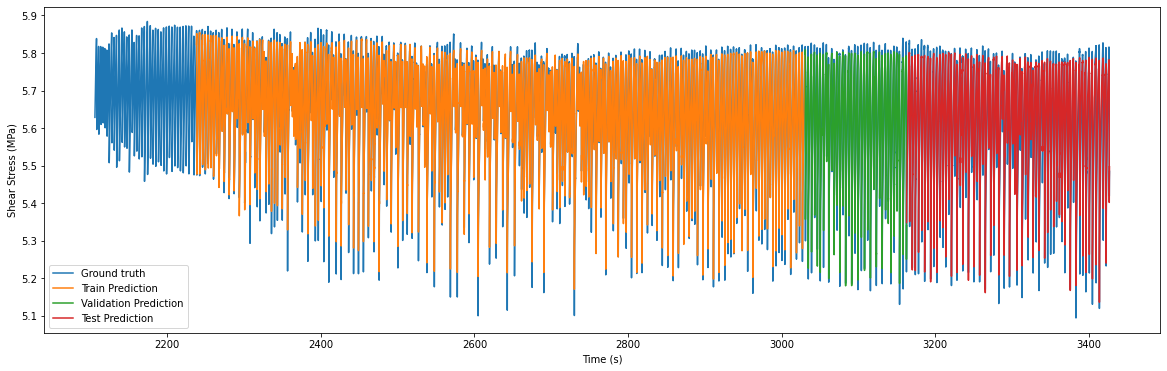

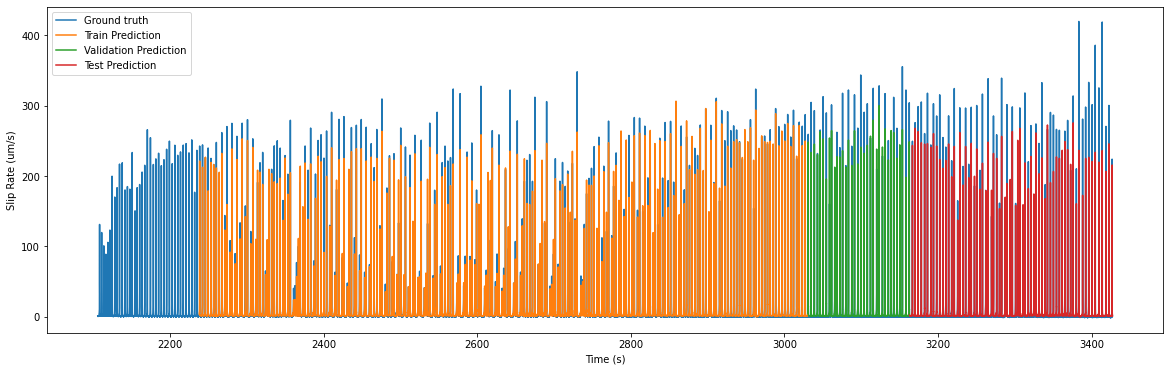

In [ ]:
# Overall plot: SS & V 
ttime = df['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.2, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.125, shuffle=False)

traintime = traintime[13210:92469] 

fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf_SS)
plt.plot(traintime, y_predtrain_SS)
plt.plot(valtime, y_predval_SS)
plt.plot(testtime, y_predtest_SS)
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

fig = plt.figure(2, figsize=(20,6))
plt.plot(ttime, ydf_V)
plt.plot(traintime, y_predtrain_V)
plt.plot(valtime,  y_predval_V)
plt.plot(testtime, y_predtest_V)
plt.xlabel('Time (s)')
plt.ylabel('Slip Rate (um/s)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

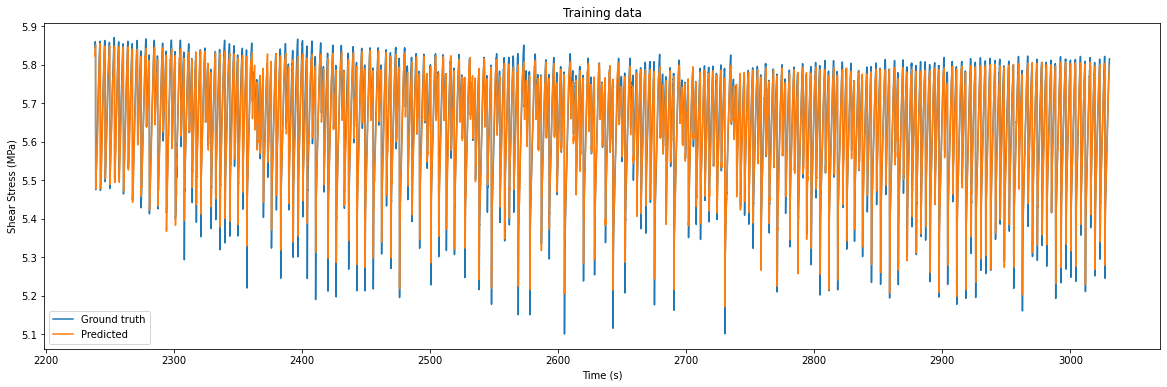

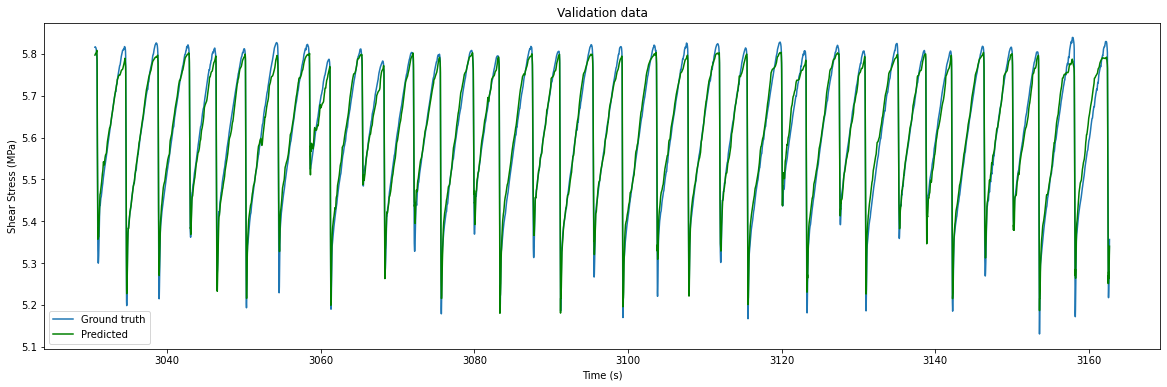

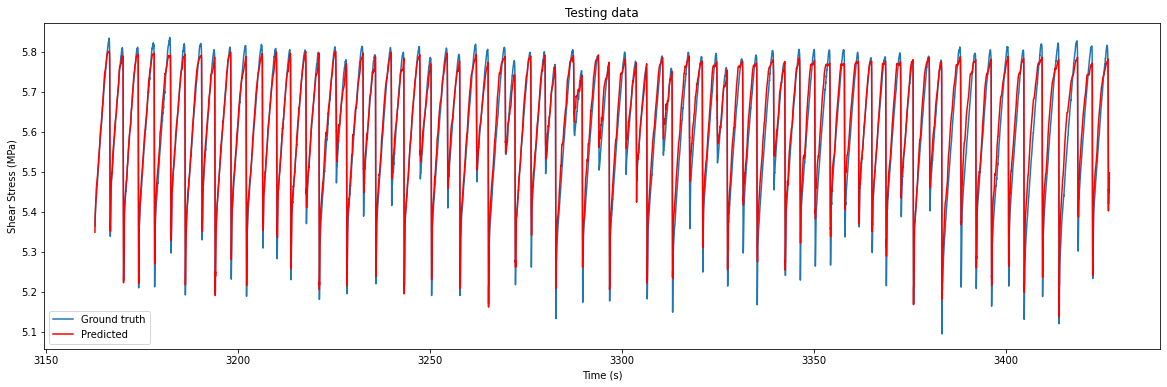

In [ ]:
# Individual plot: SS

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Shear Stress (MPa)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_SS, y_predtrain_SS, 'Training data', '')
results_plot(2, valtime, Y_val_SS, y_predval_SS, 'Validation data', 'g')
results_plot(3, testtime, y_test_SS, y_predtest_SS, 'Testing data', 'r')

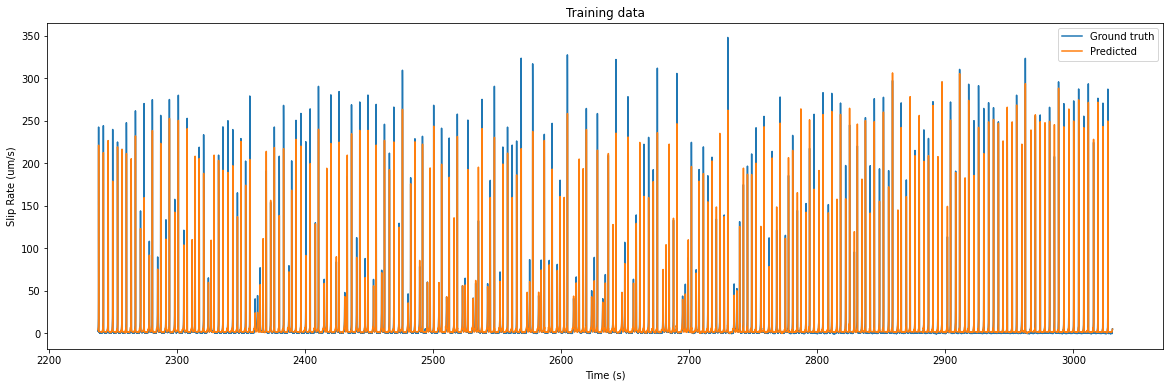

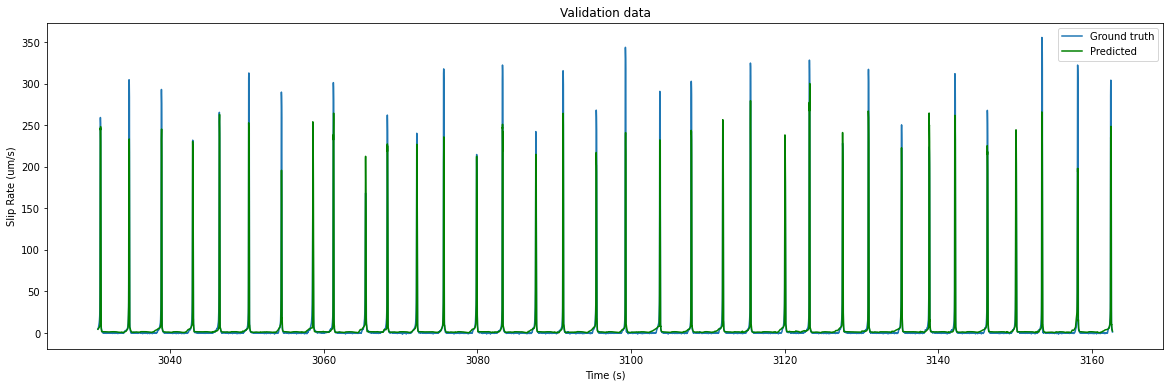

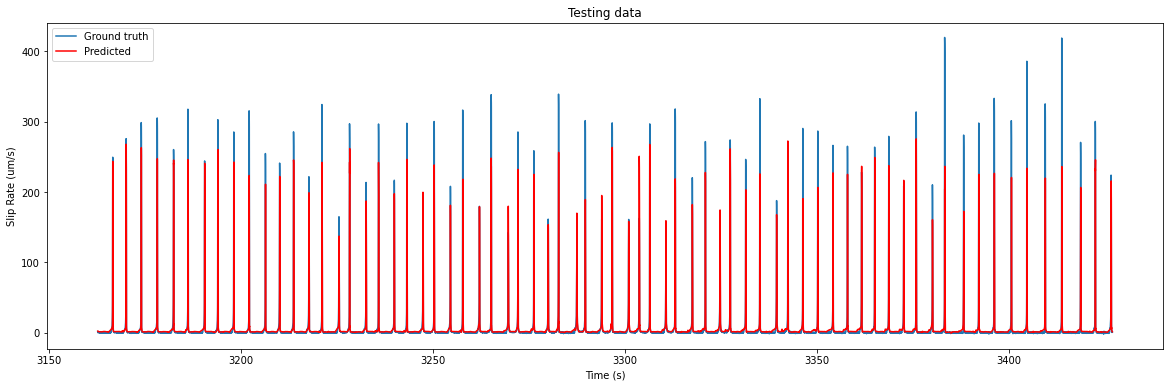

In [ ]:
# Individual plot: V

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Slip Rate (um/s)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_V, y_predtrain_V, 'Training data', '')
results_plot(2, valtime, Y_val_V, y_predval_V, 'Validation data', 'g')
results_plot(3, testtime, y_test_V, y_predtest_V, 'Testing data', 'r')

In [ ]:
# # Extract Data

# # Time 
# savetxt('Whole_time.csv', ttime, delimiter=',')
# savetxt('traintime.csv', traintime, delimiter=',')
# savetxt('valtime.csv', valtime, delimiter=',')
# savetxt('testtime.csv', testtime, delimiter=',')

# # SS
# savetxt('Y_train_SS.csv', Y_train_SS, delimiter=',')
# savetxt('Y_val_SS.csv', Y_val_SS, delimiter=',')
# savetxt('y_test_SS.csv', y_test_SS, delimiter=',')
# savetxt('y_predtrain_SS.csv', y_predtrain_SS, delimiter=',')
# savetxt('y_predval_SS.csv', y_predval_SS, delimiter=',')
# savetxt('y_predtest_SS.csv', y_predtest_SS, delimiter=',')

# # V
# savetxt('Y_train_V.csv', Y_train_V, delimiter=',')
# savetxt('Y_val_V.csv', Y_val_V, delimiter=',')
# savetxt('y_test_V.csv', y_test_V, delimiter=',')
# savetxt('y_predtrain_V.csv', y_predtrain_V, delimiter=',')
# savetxt('y_predval_V.csv', y_predval_V, delimiter=',')
# savetxt('y_predtest_V.csv', y_predtest_V, delimiter=',')

# # Download
# files.download('Whole_time.csv')
# files.download('traintime.csv')
# files.download('valtime.csv')
# files.download('testtime.csv')

# files.download('Y_train_SS.csv')
# files.download('Y_val_SS.csv')
# files.download('y_test_SS.csv')
# files.download('y_predtrain_SS.csv')
# files.download('y_predval_SS.csv')
# files.download('y_predtest_SS.csv')

# files.download('Y_train_V.csv')
# files.download('Y_val_V.csv')
# files.download('y_test_V.csv')
# files.download('y_predtrain_V.csv')
# files.download('y_predval_V.csv')
# files.download('y_predtest_V.csv')